<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

Notes:
- I have no labels for test here, so I am dropping 'test.zip' related code. I can split train into train, val, test; in fact I don't want to have a lot of examples for train set.
- The sets are almost balanced, accuracy is ok here

In [2]:
!nvidia-smi

Fri Dec 16 20:13:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(13)
if device =='cuda':
    torch.cuda.manual_seed_all(13)

In [4]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [5]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [6]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

In [7]:
os.listdir(train_dir)[:5]

['dog.94.jpg', 'cat.3013.jpg', 'cat.2208.jpg', 'cat.2210.jpg', 'dog.8644.jpg']

In [33]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']


In [34]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
subset_train_list = cats_list[:500] + dogs_list[:500]
# subset_train_list = cats_list[:2000] + dogs_list[:2000]
# subset_train_list = cats_list[:250] + dogs_list[:250]
# subset_train_list = cats_list[:150] + dogs_list[:150]
# subset_train_list = cats_list[:50] + dogs_list[:50]
val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(subset_train_list),len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
# assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
# assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
assert subset_train_list[4] == 'local_data/train/dog.445.jpg' # 1000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.7661.jpg' # 300 imgs
# assert subset_train_list[4] == 'local_data/train/cat.9914.jpg' #100 imgs
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

1000 15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/dog.8008.jpg', 'local_data/train/cat.2931.jpg', 'local_data/train/cat.5763.jpg', 'local_data/train/dog.5353.jpg', 'local_data/train/dog.445.jpg', 'local_data/train/cat.7465.jpg', 'local_data/train/cat.11556.jpg', 'local_data/train/cat.10312.jpg', 'local_data/train/cat.2166.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'local_data/train/cat.1815.jpg', 'local_data/train/dog.5218.jpg', 'local_data/train/dog.5240.jpg']
test ['local_data/train/dog.1856.jpg', 'local_data/train/dog.10017.jp

In [35]:
train_list = subset_train_list # 5 batches # or 20 batches
# train_list = full_train_list

[295 966 912 722 336 465 205 699 644 643]


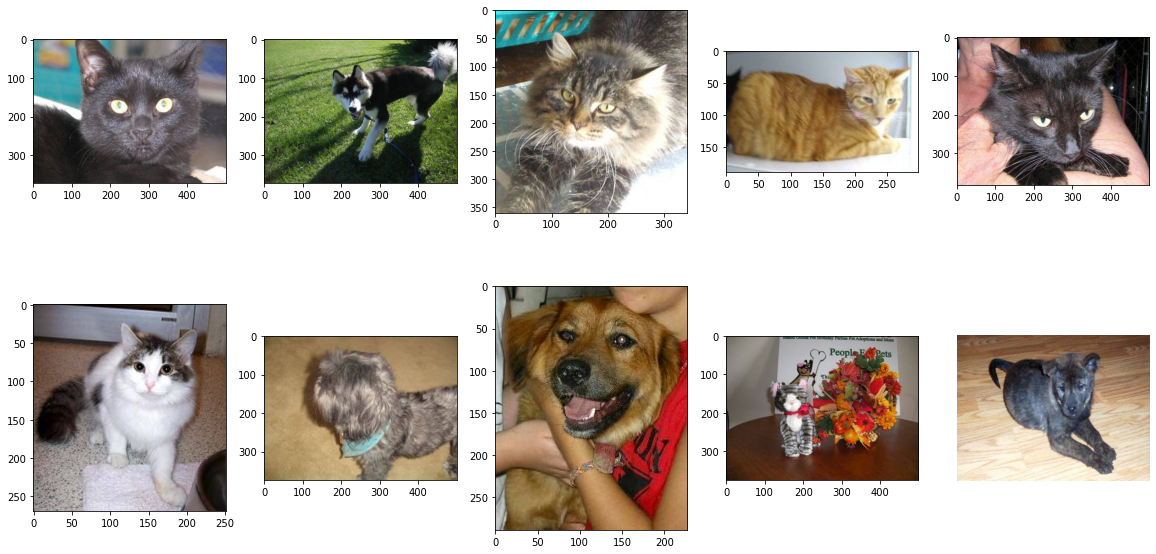

In [36]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [37]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

# Data Augmentation

In [38]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.9, 1.0)), 
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

val_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transforms = transforms.Compose([   
  transforms.Resize((224, 224)),
  # transforms.RandomResizedCrop(224),
  # transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

In [39]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [40]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [41]:
batch_size = 100 # we will use mini-batch method

In [42]:
train_data = dataset(train_list, transform=train_transforms)
val_data = dataset(val_list, transform=val_transforms)
test_data = dataset(test_list, transform=test_transforms)
visualise_train_dataset = dataset(train_list, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
vis_train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=False)

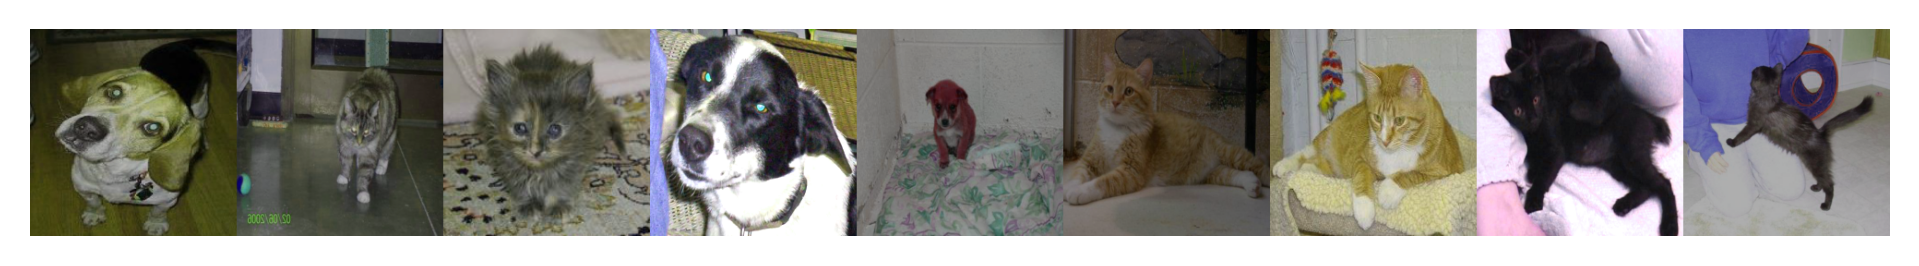

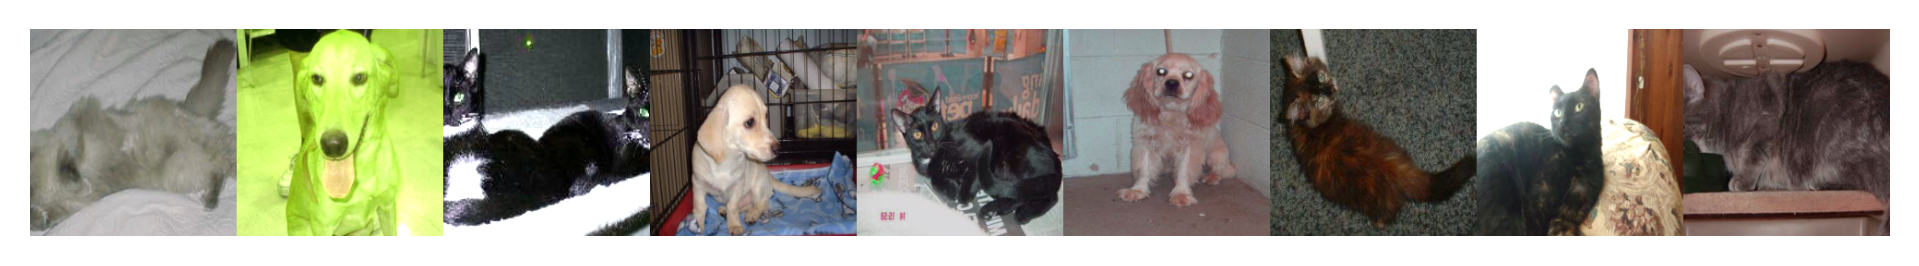

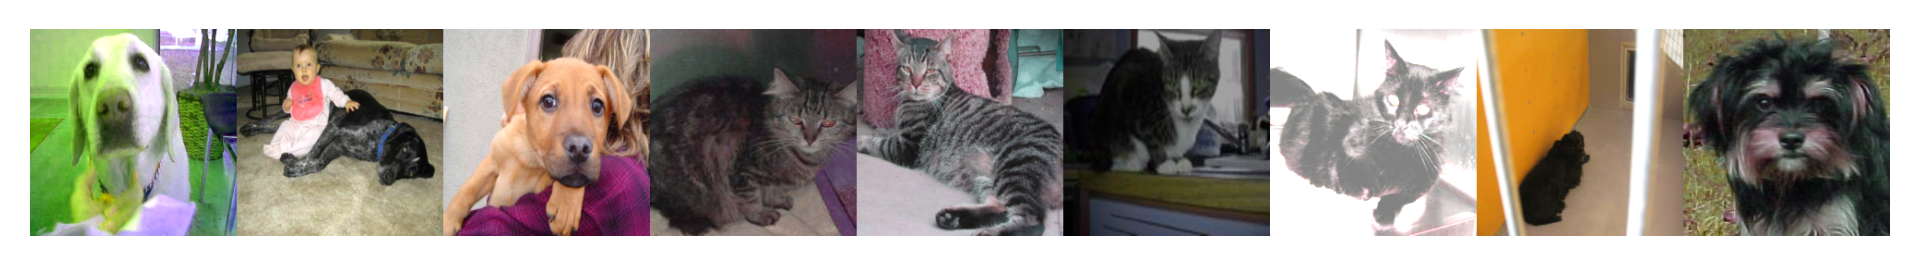

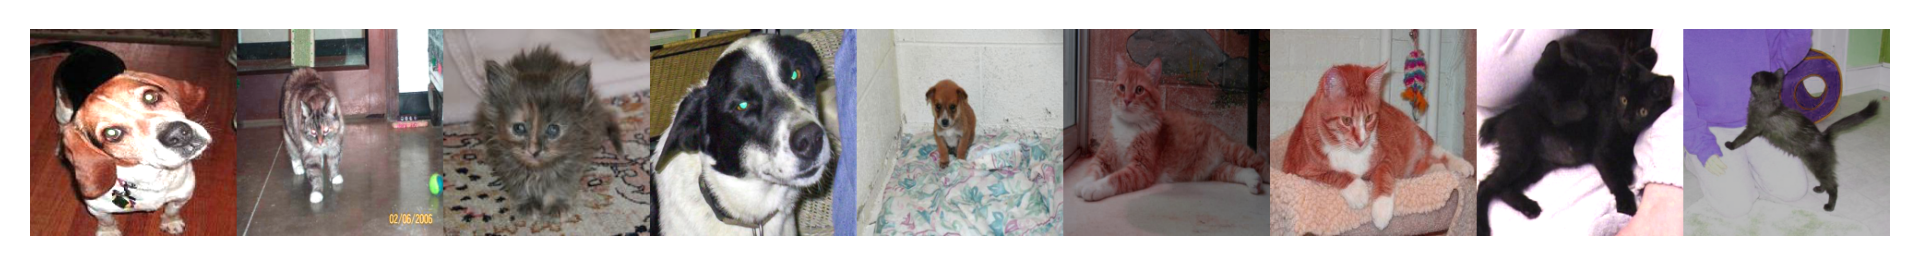

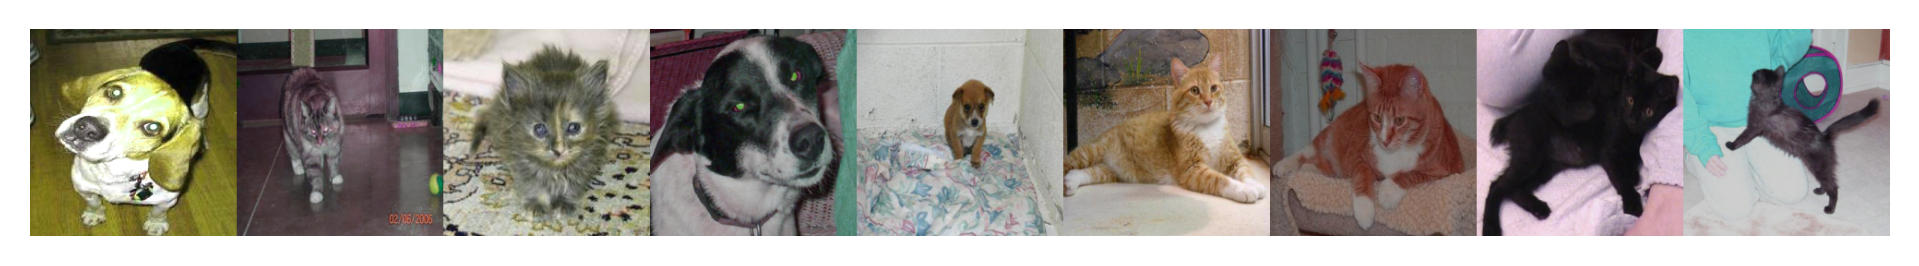

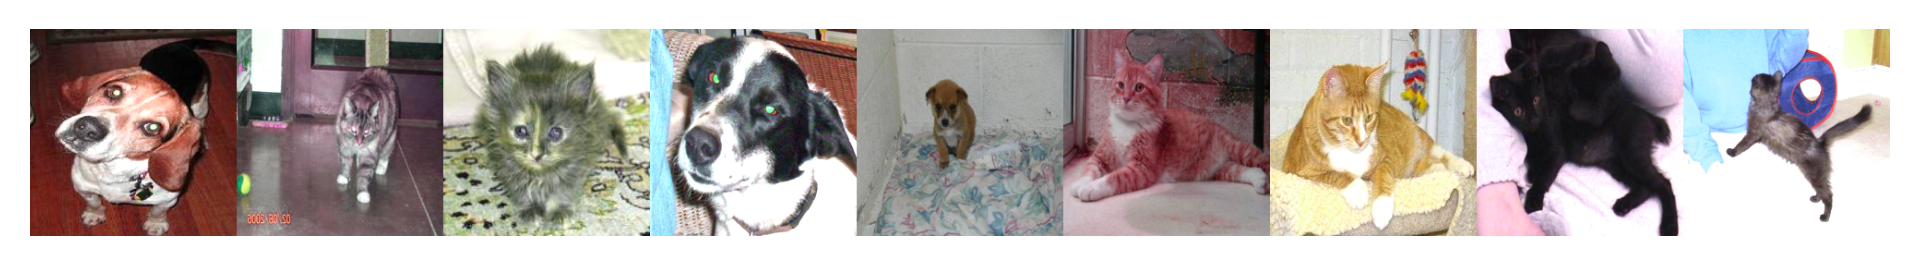

In [43]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(vis_train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))
visualize_classification(iter(vis_train_loader))

In [44]:
print(len(train_data), len(train_loader), len(test_loader))

1000 10 50


In [45]:
print(sum(1 for filename in train_data.file_list if 'cat' in filename))
print(sum(1 for filename in train_data.file_list if 'dog' in filename))
print(sum(1 for filename in val_data.file_list if 'cat' in filename))
print(sum(1 for filename in val_data.file_list if 'dog' in filename))
print(sum(1 for filename in test_data.file_list if 'cat' in filename))
print(sum(1 for filename in test_data.file_list if 'dog' in filename))

500
500
2500
2500
2500
2500


In [46]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [47]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [48]:
model = model.to(device)
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [49]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [50]:
def eval_model(loader: torch.utils.data.dataloader.DataLoader, model: nn.Module, description: str="Evaluation:") -> tuple: #[torch.Tensor, torch.Tensor] detailed tuple types only in Python >3.9, colab has 3.8.16
  epoch_accuracy=0
  epoch_loss =0
  with torch.no_grad():
    with tqdm(loader, unit="iteration") as tqdm_wrapped_loader:
      tqdm_wrapped_loader.set_description(description)
      for data, label in tqdm_wrapped_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output,label)


          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/ len(loader)
          epoch_loss += loss/ len(loader)
          tqdm_wrapped_loader.set_postfix(epoch_accuracy=epoch_accuracy, loss=epoch_loss)
  return epoch_accuracy, epoch_loss

In [51]:
epochs = 100 #10
min_val_loss = float('inf')
epochs_since_min_loss = 0
patience = 7
final_scores = {}

for epoch in range(epochs):
    print("\n","="*30,"\n")
    epoch_loss = 0
    epoch_accuracy = 0
    
    with tqdm(train_loader, unit="iteration") as tepoch:
      
      for data, label in tepoch:
          tepoch.set_description(f"Training epoch {epoch}")
          data = data.to(device)
          label = label.to(device)
          
          output = model(data)
          loss = criterion(output, label)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)
          tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))

    
      # with torch.no_grad():
      #     epoch_val_accuracy=0
      #     epoch_val_loss =0
      #     with tqdm(val_loader, unit="iteration") as tqdm_wrapped_valid_loader:
      #       tepoch.set_description(f"Validation after epoch {epoch}")
      #       for data, label in tqdm_wrapped_valid_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           val_output = model(data)
      #           val_loss = criterion(val_output,label)
                
                
      #           acc = ((val_output.argmax(dim=1) == label).float().mean())
      #           epoch_val_accuracy += acc/ len(val_loader)
      #           epoch_val_loss += val_loss/ len(val_loader)
      #           tqdm_wrapped_valid_loader.set_postfix(epoch_val_accuracy=epoch_val_accuracy, val_loss=val_loss)
    epoch_val_accuracy,epoch_val_loss = eval_model(val_loader, model, f"Validation after epoch {epoch}")
    print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))
    scalar_val_loss = epoch_val_loss.item()
    if scalar_val_loss < min_val_loss:
      min_val_loss = scalar_val_loss 
      epochs_since_min_loss = 0 
      final_scores['epoch']=epoch
      final_scores['epoch_train_accuracy']=epoch_accuracy
      final_scores['epoch_train_loss']=epoch_loss
      final_scores['epoch_val_loss']=epoch_val_loss
      final_scores['epoch_val_accuracy']=epoch_val_accuracy


      print("New best model, min_val_loss:", min_val_loss)


      # with torch.no_grad():
      #     epoch_test_accuracy=0
      #     epoch_test_loss =0
      #     with tqdm(test_loader, unit="iteration") as tqdm_wrapped_test_loader:
      #       tepoch.set_description(f"Test after epoch {epoch}")
      #       for data, label in tqdm_wrapped_test_loader:
      #           data = data.to(device)
      #           label = label.to(device)
                
      #           test_output = model(data)
      #           test_loss = criterion(test_output,label)
                
                
      #           acc = ((test_output.argmax(dim=1) == label).float().mean())
      #           epoch_test_accuracy += acc/ len(test_loader)
      #           epoch_test_loss += test_loss/ len(test_loader)
      #           tqdm_wrapped_test_loader.set_postfix(epoch_test_accuracy=epoch_test_accuracy, test_loss=test_loss)

      # epoch_test_accuracy,epoch_test_loss = eval_model(test_loader, model, f"Test after epoch {epoch}")
      # print('Epoch : {}, test_accuracy : {}, test_loss : {}'.format(epoch, epoch_test_accuracy,epoch_test_loss))



    else:
      epochs_since_min_loss+=1
      print("epochs_since_min_loss",epochs_since_min_loss)
    if epochs_since_min_loss > patience:
      print(f"Early stopping. \n\n Best model scores: {final_scores}")
      break

Training epoch 0: 100%|██████████| 10/10 [00:14<00:00,  1.47s/iteration, accuracy=tensor(49.9000, device='cuda:0'), loss=0.842]


Epoch : 0, train accuracy : 0.4989999830722809, train loss : 3.0159571170806885


Validation after epoch 0: 100%|██████████| 50/50 [00:30<00:00,  1.64iteration/s, epoch_accuracy=tensor(0.5770, device='cuda:0'), loss=tensor(0.7064, device='cuda:0')]


Epoch : 0, val_accuracy : 0.5769999623298645, val_loss : 0.7063500881195068
New best model, min_val_loss: 0.7063500881195068




Training epoch 1: 100%|██████████| 10/10 [00:14<00:00,  1.46s/iteration, accuracy=tensor(53.6000, device='cuda:0'), loss=0.709]


Epoch : 1, train accuracy : 0.5360000133514404, train loss : 0.7018302083015442


Validation after epoch 1: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.5976, device='cuda:0'), loss=tensor(0.6733, device='cuda:0')]


Epoch : 1, val_accuracy : 0.5975999236106873, val_loss : 0.6733266115188599
New best model, min_val_loss: 0.6733266115188599




Training epoch 2: 100%|██████████| 10/10 [00:14<00:00,  1.46s/iteration, accuracy=tensor(59.9000, device='cuda:0'), loss=0.662]


Epoch : 2, train accuracy : 0.5989999771118164, train loss : 0.6756308078765869


Validation after epoch 2: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.6148, device='cuda:0'), loss=tensor(0.6578, device='cuda:0')]


Epoch : 2, val_accuracy : 0.6148000359535217, val_loss : 0.6577954292297363
New best model, min_val_loss: 0.6577954292297363




Training epoch 3: 100%|██████████| 10/10 [00:14<00:00,  1.46s/iteration, accuracy=tensor(60.0000, device='cuda:0'), loss=0.668]


Epoch : 3, train accuracy : 0.6000000238418579, train loss : 0.663987398147583


Validation after epoch 3: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.6130, device='cuda:0'), loss=tensor(0.6501, device='cuda:0')]


Epoch : 3, val_accuracy : 0.6130000352859497, val_loss : 0.6500787734985352
New best model, min_val_loss: 0.6500787734985352




Training epoch 4: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(61.2000, device='cuda:0'), loss=0.649]


Epoch : 4, train accuracy : 0.6119999885559082, train loss : 0.6503131985664368


Validation after epoch 4: 100%|██████████| 50/50 [00:30<00:00,  1.64iteration/s, epoch_accuracy=tensor(0.6256, device='cuda:0'), loss=tensor(0.6441, device='cuda:0')]


Epoch : 4, val_accuracy : 0.6255999803543091, val_loss : 0.6441438794136047
New best model, min_val_loss: 0.6441438794136047




Training epoch 5: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(61.9000, device='cuda:0'), loss=0.64]


Epoch : 5, train accuracy : 0.6189999580383301, train loss : 0.6479729413986206


Validation after epoch 5: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.6148, device='cuda:0'), loss=tensor(0.6451, device='cuda:0')]


Epoch : 5, val_accuracy : 0.6148000359535217, val_loss : 0.6450548768043518
epochs_since_min_loss 1




Training epoch 6: 100%|██████████| 10/10 [00:14<00:00,  1.47s/iteration, accuracy=tensor(60.6000, device='cuda:0'), loss=0.626]


Epoch : 6, train accuracy : 0.6060000061988831, train loss : 0.6507253646850586


Validation after epoch 6: 100%|██████████| 50/50 [00:29<00:00,  1.69iteration/s, epoch_accuracy=tensor(0.6192, device='cuda:0'), loss=tensor(0.6419, device='cuda:0')]


Epoch : 6, val_accuracy : 0.6191999912261963, val_loss : 0.6418779492378235
New best model, min_val_loss: 0.6418779492378235




Training epoch 7: 100%|██████████| 10/10 [00:14<00:00,  1.46s/iteration, accuracy=tensor(62., device='cuda:0'), loss=0.652]


Epoch : 7, train accuracy : 0.6200000047683716, train loss : 0.6468161344528198


Validation after epoch 7: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.6298, device='cuda:0'), loss=tensor(0.6391, device='cuda:0')]


Epoch : 7, val_accuracy : 0.6297999024391174, val_loss : 0.6390512585639954
New best model, min_val_loss: 0.6390512585639954




Training epoch 8: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(58.9000, device='cuda:0'), loss=0.641]


Epoch : 8, train accuracy : 0.5889999270439148, train loss : 0.6591597199440002


Validation after epoch 8: 100%|██████████| 50/50 [00:30<00:00,  1.64iteration/s, epoch_accuracy=tensor(0.6394, device='cuda:0'), loss=tensor(0.6349, device='cuda:0')]


Epoch : 8, val_accuracy : 0.6394000053405762, val_loss : 0.6349083781242371
New best model, min_val_loss: 0.6349083781242371




Training epoch 9: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(62.3000, device='cuda:0'), loss=0.654]


Epoch : 9, train accuracy : 0.6229999661445618, train loss : 0.6455284953117371


Validation after epoch 9: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.6160, device='cuda:0'), loss=tensor(0.6541, device='cuda:0')]


Epoch : 9, val_accuracy : 0.6159998774528503, val_loss : 0.6541239023208618
epochs_since_min_loss 1




Training epoch 10: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(61.6000, device='cuda:0'), loss=0.593]


Epoch : 10, train accuracy : 0.6159999966621399, train loss : 0.6554700136184692


Validation after epoch 10: 100%|██████████| 50/50 [00:29<00:00,  1.72iteration/s, epoch_accuracy=tensor(0.6466, device='cuda:0'), loss=tensor(0.6351, device='cuda:0')]


Epoch : 10, val_accuracy : 0.6465998888015747, val_loss : 0.6350688934326172
epochs_since_min_loss 2




Training epoch 11: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(65.2000, device='cuda:0'), loss=0.618]


Epoch : 11, train accuracy : 0.6519999504089355, train loss : 0.6366831064224243


Validation after epoch 11: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.6524, device='cuda:0'), loss=tensor(0.6232, device='cuda:0')]


Epoch : 11, val_accuracy : 0.6523998975753784, val_loss : 0.62319016456604
New best model, min_val_loss: 0.62319016456604




Training epoch 12: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(63.4000, device='cuda:0'), loss=0.619]


Epoch : 12, train accuracy : 0.6340000629425049, train loss : 0.6258635520935059


Validation after epoch 12: 100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_accuracy=tensor(0.6608, device='cuda:0'), loss=tensor(0.6148, device='cuda:0')]


Epoch : 12, val_accuracy : 0.6607999801635742, val_loss : 0.6148297786712646
New best model, min_val_loss: 0.6148297786712646




Training epoch 13: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(65.0000, device='cuda:0'), loss=0.623]


Epoch : 13, train accuracy : 0.6499999165534973, train loss : 0.6206316947937012


Validation after epoch 13: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.6590, device='cuda:0'), loss=tensor(0.6217, device='cuda:0')]


Epoch : 13, val_accuracy : 0.6589999794960022, val_loss : 0.6217039227485657
epochs_since_min_loss 1




Training epoch 14: 100%|██████████| 10/10 [00:14<00:00,  1.46s/iteration, accuracy=tensor(65.2000, device='cuda:0'), loss=0.62]


Epoch : 14, train accuracy : 0.6520000100135803, train loss : 0.6268697381019592


Validation after epoch 14: 100%|██████████| 50/50 [00:29<00:00,  1.72iteration/s, epoch_accuracy=tensor(0.6448, device='cuda:0'), loss=tensor(0.6292, device='cuda:0')]


Epoch : 14, val_accuracy : 0.6447998881340027, val_loss : 0.6291662454605103
epochs_since_min_loss 2




Training epoch 15: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(65.5000, device='cuda:0'), loss=0.598]


Epoch : 15, train accuracy : 0.6549999117851257, train loss : 0.6329159736633301


Validation after epoch 15: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.6654, device='cuda:0'), loss=tensor(0.6161, device='cuda:0')]


Epoch : 15, val_accuracy : 0.6653999090194702, val_loss : 0.6160740256309509
epochs_since_min_loss 3




Training epoch 16: 100%|██████████| 10/10 [00:15<00:00,  1.54s/iteration, accuracy=tensor(66.6000, device='cuda:0'), loss=0.631]


Epoch : 16, train accuracy : 0.6660000085830688, train loss : 0.605705976486206


Validation after epoch 16: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.6550, device='cuda:0'), loss=tensor(0.6215, device='cuda:0')]


Epoch : 16, val_accuracy : 0.654999852180481, val_loss : 0.6215437650680542
epochs_since_min_loss 4




Training epoch 17: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(69.5000, device='cuda:0'), loss=0.485]


Epoch : 17, train accuracy : 0.6949999928474426, train loss : 0.593873143196106


Validation after epoch 17: 100%|██████████| 50/50 [00:29<00:00,  1.72iteration/s, epoch_accuracy=tensor(0.6762, device='cuda:0'), loss=tensor(0.6036, device='cuda:0')]


Epoch : 17, val_accuracy : 0.6761998534202576, val_loss : 0.6035745143890381
New best model, min_val_loss: 0.6035745143890381




Training epoch 18: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(69.2000, device='cuda:0'), loss=0.594]


Epoch : 18, train accuracy : 0.6919999122619629, train loss : 0.5908991098403931


Validation after epoch 18: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.6544, device='cuda:0'), loss=tensor(0.6202, device='cuda:0')]


Epoch : 18, val_accuracy : 0.6544000506401062, val_loss : 0.6202144622802734
epochs_since_min_loss 1




Training epoch 19: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(70.1000, device='cuda:0'), loss=0.573]


Epoch : 19, train accuracy : 0.7009999752044678, train loss : 0.5894201397895813


Validation after epoch 19: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.6480, device='cuda:0'), loss=tensor(0.6228, device='cuda:0')]


Epoch : 19, val_accuracy : 0.6479998826980591, val_loss : 0.6227639317512512
epochs_since_min_loss 2




Training epoch 20: 100%|██████████| 10/10 [00:15<00:00,  1.55s/iteration, accuracy=tensor(68.7000, device='cuda:0'), loss=0.541]


Epoch : 20, train accuracy : 0.687000036239624, train loss : 0.5924689769744873


Validation after epoch 20: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.6862, device='cuda:0'), loss=tensor(0.5900, device='cuda:0')]


Epoch : 20, val_accuracy : 0.6861997842788696, val_loss : 0.5899916291236877
New best model, min_val_loss: 0.5899916291236877




Training epoch 21: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(72.6000, device='cuda:0'), loss=0.464]


Epoch : 21, train accuracy : 0.7259999513626099, train loss : 0.559630274772644


Validation after epoch 21: 100%|██████████| 50/50 [00:28<00:00,  1.74iteration/s, epoch_accuracy=tensor(0.6930, device='cuda:0'), loss=tensor(0.5861, device='cuda:0')]


Epoch : 21, val_accuracy : 0.6929999589920044, val_loss : 0.586107075214386
New best model, min_val_loss: 0.586107075214386




Training epoch 22: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(73.7000, device='cuda:0'), loss=0.491]


Epoch : 22, train accuracy : 0.7369999885559082, train loss : 0.538189709186554


Validation after epoch 22: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.7032, device='cuda:0'), loss=tensor(0.5759, device='cuda:0')]


Epoch : 22, val_accuracy : 0.7031998634338379, val_loss : 0.575878918170929
New best model, min_val_loss: 0.575878918170929




Training epoch 23: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(71., device='cuda:0'), loss=0.492]


Epoch : 23, train accuracy : 0.7100000381469727, train loss : 0.5585424900054932


Validation after epoch 23: 100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_accuracy=tensor(0.6972, device='cuda:0'), loss=tensor(0.5742, device='cuda:0')]


Epoch : 23, val_accuracy : 0.6971999406814575, val_loss : 0.5741763114929199
New best model, min_val_loss: 0.5741763114929199




Training epoch 24: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(72.9000, device='cuda:0'), loss=0.538]


Epoch : 24, train accuracy : 0.7290000319480896, train loss : 0.5453709363937378


Validation after epoch 24: 100%|██████████| 50/50 [00:29<00:00,  1.69iteration/s, epoch_accuracy=tensor(0.6838, device='cuda:0'), loss=tensor(0.5921, device='cuda:0')]


Epoch : 24, val_accuracy : 0.6837999224662781, val_loss : 0.5920959115028381
epochs_since_min_loss 1




Training epoch 25: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(74.2000, device='cuda:0'), loss=0.534]


Epoch : 25, train accuracy : 0.7420000433921814, train loss : 0.5356137752532959


Validation after epoch 25: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.7094, device='cuda:0'), loss=tensor(0.5759, device='cuda:0')]


Epoch : 25, val_accuracy : 0.7093999981880188, val_loss : 0.5758797526359558
epochs_since_min_loss 2




Training epoch 26: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(74.9000, device='cuda:0'), loss=0.471]


Epoch : 26, train accuracy : 0.7490000128746033, train loss : 0.5312710404396057


Validation after epoch 26: 100%|██████████| 50/50 [00:29<00:00,  1.70iteration/s, epoch_accuracy=tensor(0.7246, device='cuda:0'), loss=tensor(0.5573, device='cuda:0')]


Epoch : 26, val_accuracy : 0.7245998382568359, val_loss : 0.5573222041130066
New best model, min_val_loss: 0.5573222041130066




Training epoch 27: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(73.9000, device='cuda:0'), loss=0.424]


Epoch : 27, train accuracy : 0.7390000224113464, train loss : 0.5160617828369141


Validation after epoch 27: 100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_accuracy=tensor(0.7156, device='cuda:0'), loss=tensor(0.5575, device='cuda:0')]


Epoch : 27, val_accuracy : 0.7156000137329102, val_loss : 0.5575265884399414
epochs_since_min_loss 1




Training epoch 28: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(77.6000, device='cuda:0'), loss=0.422]


Epoch : 28, train accuracy : 0.7760000824928284, train loss : 0.46398571133613586


Validation after epoch 28: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.7144, device='cuda:0'), loss=tensor(0.5723, device='cuda:0')]


Epoch : 28, val_accuracy : 0.7143998742103577, val_loss : 0.5722565054893494
epochs_since_min_loss 2




Training epoch 29: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(77.6000, device='cuda:0'), loss=0.444]


Epoch : 29, train accuracy : 0.7759999632835388, train loss : 0.4747912287712097


Validation after epoch 29: 100%|██████████| 50/50 [00:29<00:00,  1.72iteration/s, epoch_accuracy=tensor(0.7032, device='cuda:0'), loss=tensor(0.5814, device='cuda:0')]


Epoch : 29, val_accuracy : 0.7032000422477722, val_loss : 0.5814229249954224
epochs_since_min_loss 3




Training epoch 30: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(79.2000, device='cuda:0'), loss=0.397]


Epoch : 30, train accuracy : 0.7920000553131104, train loss : 0.46582213044166565


Validation after epoch 30: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7180, device='cuda:0'), loss=tensor(0.5639, device='cuda:0')]


Epoch : 30, val_accuracy : 0.7179999947547913, val_loss : 0.563916802406311
epochs_since_min_loss 4




Training epoch 31: 100%|██████████| 10/10 [00:14<00:00,  1.43s/iteration, accuracy=tensor(78.3000, device='cuda:0'), loss=0.363]


Epoch : 31, train accuracy : 0.7829999327659607, train loss : 0.47213825583457947


Validation after epoch 31: 100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_accuracy=tensor(0.7226, device='cuda:0'), loss=tensor(0.5570, device='cuda:0')]


Epoch : 31, val_accuracy : 0.722599983215332, val_loss : 0.5570034980773926
New best model, min_val_loss: 0.5570034980773926




Training epoch 32: 100%|██████████| 10/10 [00:14<00:00,  1.45s/iteration, accuracy=tensor(79., device='cuda:0'), loss=0.449]


Epoch : 32, train accuracy : 0.7899999618530273, train loss : 0.45609381794929504


Validation after epoch 32: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7216, device='cuda:0'), loss=tensor(0.5598, device='cuda:0')]


Epoch : 32, val_accuracy : 0.7215998768806458, val_loss : 0.5597660541534424
epochs_since_min_loss 1




Training epoch 33: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(79.5000, device='cuda:0'), loss=0.398]


Epoch : 33, train accuracy : 0.7950000166893005, train loss : 0.43635305762290955


Validation after epoch 33: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7316, device='cuda:0'), loss=tensor(0.5576, device='cuda:0')]


Epoch : 33, val_accuracy : 0.7315999865531921, val_loss : 0.5576172471046448
epochs_since_min_loss 2




Training epoch 34: 100%|██████████| 10/10 [00:14<00:00,  1.43s/iteration, accuracy=tensor(79.9000, device='cuda:0'), loss=0.438]


Epoch : 34, train accuracy : 0.7990000247955322, train loss : 0.43530604243278503


Validation after epoch 34: 100%|██████████| 50/50 [00:29<00:00,  1.72iteration/s, epoch_accuracy=tensor(0.7290, device='cuda:0'), loss=tensor(0.5664, device='cuda:0')]


Epoch : 34, val_accuracy : 0.7289999723434448, val_loss : 0.5664440393447876
epochs_since_min_loss 3




Training epoch 35: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(82.2000, device='cuda:0'), loss=0.364]


Epoch : 35, train accuracy : 0.8220000267028809, train loss : 0.4025518596172333


Validation after epoch 35: 100%|██████████| 50/50 [00:30<00:00,  1.67iteration/s, epoch_accuracy=tensor(0.7250, device='cuda:0'), loss=tensor(0.5699, device='cuda:0')]


Epoch : 35, val_accuracy : 0.7250001430511475, val_loss : 0.5699443817138672
epochs_since_min_loss 4




Training epoch 36: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(83.4000, device='cuda:0'), loss=0.393]


Epoch : 36, train accuracy : 0.8339999914169312, train loss : 0.3861269950866699


Validation after epoch 36: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7216, device='cuda:0'), loss=tensor(0.5811, device='cuda:0')]


Epoch : 36, val_accuracy : 0.7216001152992249, val_loss : 0.5811005234718323
epochs_since_min_loss 5




Training epoch 37: 100%|██████████| 10/10 [00:14<00:00,  1.43s/iteration, accuracy=tensor(83.1000, device='cuda:0'), loss=0.343]


Epoch : 37, train accuracy : 0.8309999108314514, train loss : 0.3764689564704895


Validation after epoch 37: 100%|██████████| 50/50 [00:29<00:00,  1.71iteration/s, epoch_accuracy=tensor(0.7230, device='cuda:0'), loss=tensor(0.5931, device='cuda:0')]


Epoch : 37, val_accuracy : 0.7229999899864197, val_loss : 0.5930593609809875
epochs_since_min_loss 6




Training epoch 38: 100%|██████████| 10/10 [00:14<00:00,  1.44s/iteration, accuracy=tensor(82., device='cuda:0'), loss=0.363]


Epoch : 38, train accuracy : 0.8199999928474426, train loss : 0.39550918340682983


Validation after epoch 38: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7360, device='cuda:0'), loss=tensor(0.5646, device='cuda:0')]


Epoch : 38, val_accuracy : 0.736000120639801, val_loss : 0.564584493637085
epochs_since_min_loss 7




Training epoch 39: 100%|██████████| 10/10 [00:15<00:00,  1.53s/iteration, accuracy=tensor(84.9000, device='cuda:0'), loss=0.321]


Epoch : 39, train accuracy : 0.8489999771118164, train loss : 0.35350242257118225


Validation after epoch 39: 100%|██████████| 50/50 [00:28<00:00,  1.73iteration/s, epoch_accuracy=tensor(0.7326, device='cuda:0'), loss=tensor(0.5772, device='cuda:0')]

Epoch : 39, val_accuracy : 0.7325999140739441, val_loss : 0.5771774649620056
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}


In [52]:
print(f"Early stopping. \n\n Best model scores: {final_scores}")

Early stopping. 

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}


In [53]:
dog_probs = []
model.eval()
i=0
with torch.no_grad():b
  for data, fileid in val_loader:
      i+=1
      if i>10:
        break
      data = data.to(device)
      preds = model(data)
      print(preds)
      preds_list = F.softmax(preds, dim=1)[:, 1].tolist() #https://stats.stackexchange.com/questions/542054/why-does-torchvision-models-resnet18-not-use-softmax
      dog_probs += list(zip(list(fileid), preds_list))

IndentationError: ignored

# Future experiments
1000 imgs set; or more intervals; saturate cheap experiments space.

no test
no random crop augmentation
# Results

batch=100, patience=7
============

2000 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: 
 {'epoch': 33, 'epoch_train_accuracy': tensor(0.8380, device='cuda:0'), 'epoch_train_loss': tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3896, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8188, device='cuda:0')}

Training epoch 33: 100%|██████████| 20/20 [00:25<00:00,  1.30s/iteration, accuracy=tensor(83.8000, device='cuda:0'), loss=0.395]
Epoch : 33, train accuracy : 0.8380000591278076, train loss : 0.3545871675014496
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_val_accuracy=tensor(0.8188, device='cuda:0'), val_loss=tensor(0.4697, device='cuda:0')]
Epoch : 33, val_accuracy : 0.8188000321388245, val_loss : 0.3895597457885742
New best model, min_val_loss: 0.3895597457885742



================================================

500 imgs train set,
transforms.RandomResizedCrop(224,scale=(0.6, 1.0)), 
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=.4, hue=.15),
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

Best model scores: {'epoch': 39, 'epoch_train_accuracy': tensor(0.7480, device='cuda:0'), 'epoch_train_loss': tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5940, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6928, device='cuda:0')}


Training epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.27s/iteration, accuracy=tensor(74.8000, device='cuda:0'), loss=0.504]
Epoch : 39, train accuracy : 0.7479999661445618, train loss : 0.5132189393043518
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.6928, device='cuda:0'), val_loss=tensor(0.6708, device='cuda:0')]
Epoch : 39, val_accuracy : 0.6927998661994934, val_loss : 0.5940383076667786
New best model, min_val_loss: 0.5940383076667786
100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_test_accuracy=tensor(0.6874, device='cuda:0'), test_loss=tensor(0.6752, device='cuda:0')]
Epoch : 39, test_accuracy : 0.6873999238014221, test_loss : 0.5957822799682617

================================================

500 imgs train set,
no transforms (only totensor)
fails with wrong shapes

================================================

500 imgs train set, only 224 resize
 transforms.Resize((224, 224)),


 Best model scores: {'epoch': 2, 'epoch_train_accuracy': tensor(0.6660, device='cuda:0'), 'epoch_train_loss': tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6951, device='cuda:0'), 'epoch_val_accuracy': tensor(0.5774, device='cuda:0')}


 Training epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.28iteration/s, accuracy=tensor(66.6000, device='cuda:0'), loss=0.627]
Epoch : 2, train accuracy : 0.6660000085830688, train loss : 0.6177714467048645
100%|██████████| 50/50 [00:27<00:00,  1.85iteration/s, epoch_val_accuracy=tensor(0.5774, device='cuda:0'), val_loss=tensor(0.7848, device='cuda:0')]
Epoch : 2, val_accuracy : 0.5773999691009521, val_loss : 0.6951212882995605
New best model, min_val_loss: 0.6951212882995605
100%|██████████| 50/50 [00:25<00:00,  1.95iteration/s, epoch_test_accuracy=tensor(0.5704, device='cuda:0'), test_loss=tensor(0.7834, device='cuda:0')]
Epoch : 2, test_accuracy : 0.5703999996185303, test_loss : 0.6962302327156067

note: patience in my implementation (> patience) means 8 more epochs get executed.








========================================


full train set


Training epoch 40: 100%|██████████| 150/150 [03:28<00:00,  1.39s/iteration, accuracy=tensor(96.8067, device='cuda:0'), loss=0.0306]
Epoch : 40, train accuracy : 0.9680668115615845, train loss : 0.07920999079942703
100%|██████████| 50/50 [00:30<00:00,  1.65iteration/s, epoch_val_accuracy=tensor(0.9506, device='cuda:0'), val_loss=tensor(0.1377, device='cuda:0')]
Epoch : 40, val_accuracy : 0.9506001472473145, val_loss : 0.12937913835048676
New best model, min_val_loss: 0.12937913835048676
100%|██████████| 50/50 [00:30<00:00,  1.66iteration/s, epoch_test_accuracy=tensor(0.9522, device='cuda:0'), test_loss=tensor(0.1373, device='cuda:0')]
Epoch : 40, test_accuracy : 0.9522001147270203, test_loss : 0.12997546792030334

 Best model scores: {'epoch': 40, 'epoch_train_accuracy': tensor(0.9681, device='cuda:0'), 'epoch_train_loss': tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.1294, device='cuda:0'), 'epoch_val_accuracy': tensor(0.9506, device='cuda:0')}



 ============================== 

 4000 imgs
 

Training epoch 56: 100%|██████████| 40/40 [00:50<00:00,  1.26s/iteration, accuracy=tensor(95.7750, device='cuda:0'), loss=0.112]
Epoch : 56, train accuracy : 0.9577500224113464, train loss : 0.10647499561309814
Validation after epoch 56: 100%|██████████| 50/50 [00:25<00:00,  1.94iteration/s, epoch_accuracy=tensor(0.8970, device='cuda:0'), loss=tensor(0.2677, device='cuda:0')]Epoch : 56, val_accuracy : 0.8970000147819519, val_loss : 0.26771894097328186
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 48, 'epoch_train_accuracy': tensor(0.9498, device='cuda:0'), 'epoch_train_loss': tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.2475, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8988, device='cuda:0')}


  ============================== 
1000 imgs
Training epoch 46: 100%|██████████| 10/10 [00:12<00:00,  1.25s/iteration, accuracy=tensor(82.7000, device='cuda:0'), loss=0.423]
Epoch : 46, train accuracy : 0.8270000219345093, train loss : 0.3939513862133026
Validation after epoch 46: 100%|██████████| 50/50 [00:26<00:00,  1.92iteration/s, epoch_accuracy=tensor(0.7390, device='cuda:0'), loss=tensor(0.5494, device='cuda:0')]Epoch : 46, val_accuracy : 0.7390000224113464, val_loss : 0.5493948459625244
epochs_since_min_loss 8
Early stopping. 

 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.7650, device='cuda:0'), 'epoch_train_loss': tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5249, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7464, device='cuda:0')}

[29]
0s
print(f"Early stopping. \n\n Best model scores: {final_scores}")
Early stopping. 

=============================================

300 train imgs


 Best model scores: {'epoch': 36, 'epoch_train_accuracy': tensor(0.7300, device='cuda:0'), 'epoch_train_loss': tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6209, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6694, device='cuda:0')}


 Training epoch 36: 100%|██████████| 3/3 [00:03<00:00,  1.25s/iteration, accuracy=tensor(73., device='cuda:0'), loss=0.505]
Epoch : 36, train accuracy : 0.7300000190734863, train loss : 0.5214951038360596
Validation after epoch 36: 100%|██████████| 50/50 [00:25<00:00,  1.93iteration/s, epoch_accuracy=tensor(0.6694, device='cuda:0'), loss=tensor(0.6209, device='cuda:0')]
Epoch : 36, val_accuracy : 0.6693997979164124, val_loss : 0.6209338903427124
New best model, min_val_loss: 0.6209338903427124



===================================

100 imgs train



 Best model scores: {'epoch': 26, 'epoch_train_accuracy': tensor(0.6100, device='cuda:0'), 'epoch_train_loss': tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6606, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6008, device='cuda:0')}










 ========================


 1000 imgs train 
 no random crop


 Training epoch 11: 100%|██████████| 10/10 [00:13<00:00,  1.32s/iteration, accuracy=tensor(66.1000, device='cuda:0'), loss=0.598]
Epoch : 11, train accuracy : 0.6610000133514404, train loss : 0.6124292612075806
Validation after epoch 11: 100%|██████████| 50/50 [00:28<00:00,  1.78iteration/s, epoch_accuracy=tensor(0.6646, device='cuda:0'), loss=tensor(0.6104, device='cuda:0')]
Epoch : 11, val_accuracy : 0.6645999550819397, val_loss : 0.6103843450546265
New best model, min_val_loss: 0.6103843450546265


=======

4000 imgs no random crop

Best model scores: {'epoch': 21, 'epoch_train_accuracy': tensor(0.8915, device='cuda:0'), 'epoch_train_loss': tensor(0.2574, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.4274, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8212, device='cuda:0')}



=======

4000 imgs random crop (0.9, 1.0)



 Best model scores: {'epoch': 38, 'epoch_train_accuracy': tensor(0.9482, device='cuda:0'), 'epoch_train_loss': tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.3618, device='cuda:0'), 'epoch_val_accuracy': tensor(0.8702, device='cuda:0')}


 =============

 100 (0.9,1.0)


 
 Best model scores: {'epoch': 18, 'epoch_train_accuracy': tensor(0.6400, device='cuda:0'), 'epoch_train_loss': tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6644, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6080, device='cuda:0')}

 99.9% sure it was actually 100 samples.


 ==================================

300 (0.9,1.0)
Best model scores: {'epoch': 13, 'epoch_train_accuracy': tensor(0.6600, device='cuda:0'), 'epoch_train_loss': tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.6303, device='cuda:0'), 'epoch_val_accuracy': tensor(0.6474, device='cuda:0')}

==================================


1000 (0.9, 1.0)

 Best model scores: {'epoch': 31, 'epoch_train_accuracy': tensor(0.7830, device='cuda:0'), 'epoch_train_loss': tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>), 'epoch_val_loss': tensor(0.5570, device='cuda:0'), 'epoch_val_accuracy': tensor(0.7226, device='cuda:0')}